In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import Tensor
import abc
from torch.distributions import MultivariateNormal, Poisson
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module
from torch import nn
from torch.optim.lr_scheduler import StepLR
from main import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import pickle
from scipy.interpolate import CubicSpline
from sklearn.metrics import r2_score

In [2]:
data = pickle.load(open('data/Doherty_example.pickled', 'rb')) # load example data
binsize = 25 # binsize in ms
start = 0
data_len = 1000 # number of time bins to use for fitting
timepoints = np.arange(start, data_len+start) #subsample ~40 seconds of data so things will run somewhat quicker
print(data['Y'].shape)
fit_data = {'Y': data['Y'][..., timepoints], 'locs': data['locs'][timepoints, :], 'targets': data['targets'][timepoints, :], 'binsize': binsize}
# fit_data = {'Y': data['Y'], 'locs': data['locs'], 'targets': data['targets'], 'binsize': binsize}
Y = fit_data['Y'] # these are the actual recordings and is the input to our model
targets = fit_data['targets'] # these are the target locations
locs = fit_data['locs'] # these are the hand positions

Y = Y[:, np.mean(Y,axis = (0, 2))/0.025 > 8, :] #subsample highly active neurons so things will run a bit quicker
# Y_test = Y[..., 1000:] # hold out some data for testing
# Y = Y[..., :1000] # use first 1000 time bins for training
print(Y.shape)
ntrials, n, T = Y.shape # Y should have shape: [number of trials (here 1) x neurons x time points]

ts = np.arange(Y.shape[-1])*fit_data['binsize'] # measured in ms
cs = CubicSpline(ts, locs) # fit cubic spline to behavior
delay = 120
vels = cs(ts, 1) # velocity (first derivative)


(1, 200, 70482)
(1, 102, 1000)


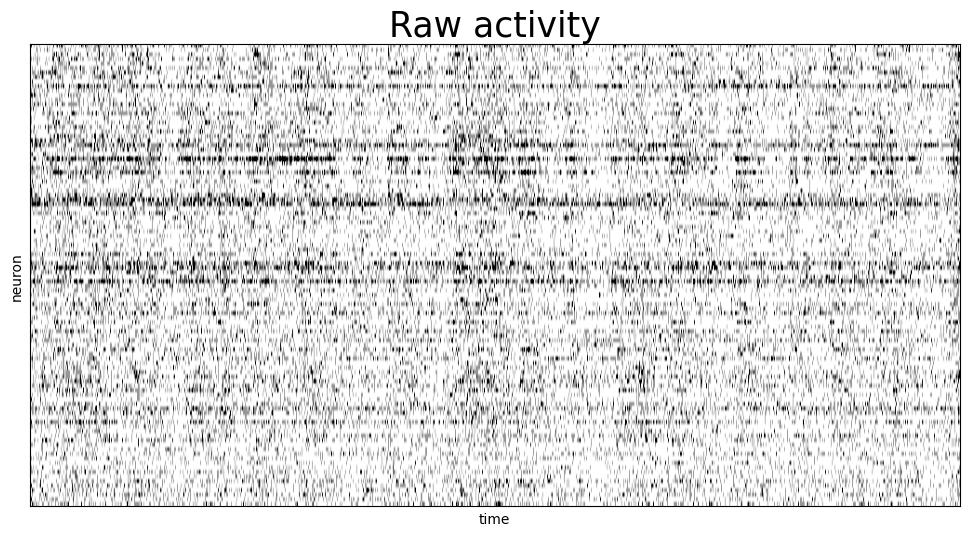

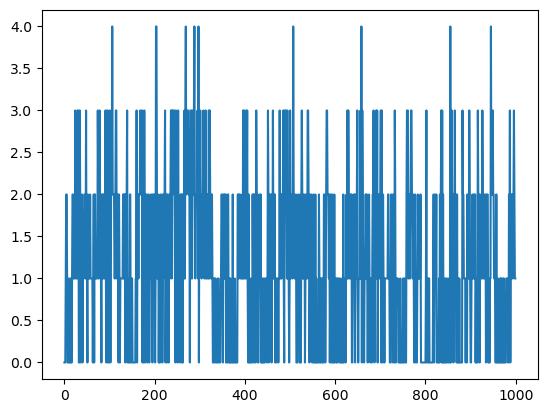

In [3]:
plt.figure(figsize = (12, 6))
plt.imshow(Y[0, ...], cmap = 'Greys', aspect = 'auto', vmin = np.quantile(Y, 0.01), vmax = np.quantile(Y, 0.99))
plt.xlabel('time')
plt.ylabel('neuron')
plt.title('Raw activity', fontsize = 25)
plt.xticks([])
plt.yticks([])
plt.show()

# Plot spikes for neuron with highest firing rate
# plt.figure(figsize = (12, 6))
plt.plot(Y[0, np.argmax(np.mean(Y, axis = -1)), :])
plt.show()

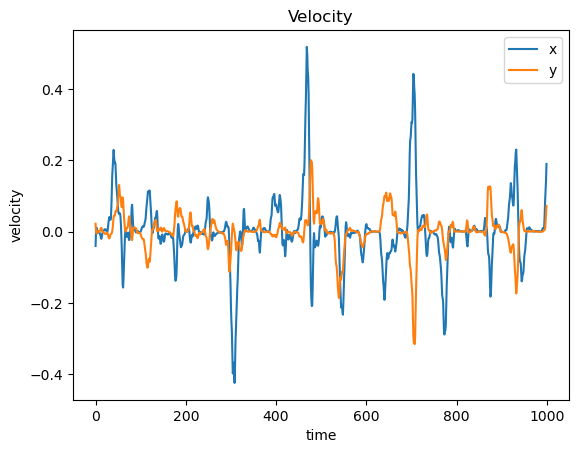

(1, 102, 1000) (1000, 2)


In [4]:
plt.plot(vels[:, 0], label = 'x')
plt.plot(vels[:, 1], label = 'y')
plt.legend()
plt.xlabel('time')
plt.ylabel('velocity')
plt.title('Velocity', fontsize = 12)
plt.show()

print(Y.shape, vels.shape)

torch.Size([1, 10, 1000])
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
(1, 102, 1000) torch.Size([1, 10, 1000])
(1, 102, 1000) torch.Size([1, 10, 1000])


step 0 LL -0.44479038783482144
step 1 LL -0.43438922991071427
step 2 LL -0.4251552036830357
step 3 LL -0.41682198660714287
step 4 LL -0.40924797712053573
step 5 LL -0.4024703543526786
step 6 LL -0.39643896484375
step 7 LL -0.3912346540178571
step 8 LL -0.38676136997767857
step 9 LL -0.38294391741071426
step 10 LL -0.379744140625
step 11 LL -0.3771553431919643
step 12 LL -0.3751155831473214
step 13 LL -0.3736210239955357
step 14 LL -0.3725031389508929
step 15 LL -0.3717892717633929
step 16 LL -0.37138211495535717
step 17 LL -0.37122879464285713
step 18 LL -0.3712617885044643
step 19 LL -0.37140771484375
step 20 LL -0.37167027064732144
step 21 LL -0.37192836216517855
step 22 LL -0.37224658203125
step 23 LL -0.37247119140625
step 24 LL -0.37271240234375
step 25 LL -0.37286125837053574
step 26 LL -0.37289013671875
step 27 LL -0.3728917410714286
step 28 LL -0.37276276506696426
step 29 LL -0.3725664760044643
step 30 LL -0.3722826450892857
step 31 LL -0.37197314453125
step 32 LL -0.3716143973

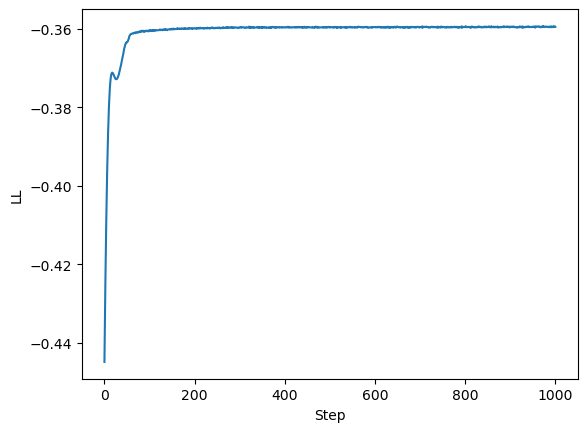

In [5]:
link_fn = torch.nn.functional.softplus
# link_fn = torch.exp
lik = Poisson_noise()

# link_fn = lambda x: x
# lik = Negative_binomial_noise(Y=Tensor(Y))

np.random.seed(0)
torch.manual_seed(0)

# train_len = 1000
# v = vels.T[None, ...]
# v_train = v[..., :train_len]
# Y_train = Y[..., :train_len]
# print(v_train.shape)
# model = LDS(Tensor(v_train), Tensor(Y_train), lik, link_fn=link_fn, fixed_d=False)
# train_params = {'batch_size': None, 'n_mc': 200, 'lrate': 1e-2}
# model.train_supervised_model(model.training_params(**train_params))
# model.plot_LL()

suffix = '10'

# Fixed generative model
z = Tensor(np.load('z_hat' + suffix + '.npy'))[..., start:start+data_len]
print(z.shape)
A = Tensor(np.load('params/A' + suffix + '.npy'))[None, ...].to(device)
B = Tensor(np.load('params/B' + suffix + '.npy'))[None, ...].to(device)
W = np.load('params/W' + suffix + '.npy')
mu0 = Tensor(np.load('params/mu0' + suffix + '.npy'))[None, ...].to(device)
Sigma0_half = Tensor(np.load('params/Sigma0_half' + suffix + '.npy'))[None, ...].to(device)

def is_lower_triangular(tensor):
    return torch.all(tensor.triu(1) == 0)
print(is_lower_triangular(Tensor(Sigma0_half)))
print(is_lower_triangular(Tensor(B)))

# print(B - torch.linalg.cholesky(B @ B.transpose(-1,-2)))
def convert_to_trials(_Y, _v, t):
    assert _Y.shape[-1] % t == 0
    ntrials = _Y.shape[-1] // t
    Y = _Y.reshape(ntrials, -1, t)
    v = _v.reshape(ntrials, -1, t)
    return Y, v

print(Y.shape, z.shape)
Y_train, z_train = convert_to_trials(Y, z, 1000)
print(Y_train.shape, z_train.shape)

# train_len = 1000
# # Y_train = Y[..., :train_len]
# z_train = z[..., :train_len]
_W = torch.randn(1, z_train.shape[1], z_train.shape[1]).to(device) / np.sqrt(z_train.shape[1])
_C = torch.randn(1, Y_train.shape[1], z_train.shape[1]).to(device) / np.sqrt(z_train.shape[1])
model = LDS(z_train, Tensor(Y_train), lik, link_fn=link_fn, A=A, B=B, mu0=mu0, Sigma0_half=Sigma0_half, trained_z=True, fixed_d=False, single_sigma_x=False, W=_W, C=_C)
# train_params = {'batch_size': 10, 'n_mc': 50, 'lrate': 5e-2, 'max_steps': 1001, 'step_size': 1000}
train_params = {'batch_size': None, 'n_mc': 100, 'lrate': 5e-2, 'max_steps': 1001, 'step_size': 1000}
model.train_supervised_model(model.training_params(**train_params))
model.plot_LL()

tensor([[-6.9908e+01,  2.8391e+01,  5.4844e+01, -5.5358e+01, -1.4777e+01,
          1.7094e+01,  6.2876e+01,  3.1888e+01,  7.2731e+00,  7.6828e+00,
          2.6507e+01, -1.3023e+01,  3.2905e+01, -1.9022e+01, -2.0828e+01,
          2.6061e+01, -1.7912e+01, -4.4986e+01,  3.1990e+01,  1.5758e+01,
          6.3956e+01, -4.9289e+01,  3.1886e+01,  3.6616e+01, -5.0910e+01,
          4.3498e+01,  6.2277e+01,  1.1635e+01,  4.9308e+01,  3.1079e+01,
          7.9237e+01, -5.0743e+01, -3.7092e+01, -6.3118e+00, -1.0781e+01,
          1.7412e+00,  2.2452e+01,  6.2547e+01, -6.9238e-02, -2.2617e+01,
          3.8387e+01,  2.6394e+01, -1.8181e+01,  2.7212e+01,  3.2381e+01,
         -1.4789e+01, -5.5771e+01, -9.4351e+00, -4.6189e+01, -3.4756e+01,
          5.5500e+01, -3.5338e+00, -8.7216e+01, -1.9683e+01,  2.3080e+01,
         -5.0256e+00,  4.7042e+01,  4.5567e+01, -3.4582e+00,  4.1561e+01,
          3.0716e+01, -8.3438e+00,  1.2885e+01, -4.2656e+00,  2.0725e+01,
          9.0690e+00, -3.1130e+01,  4.

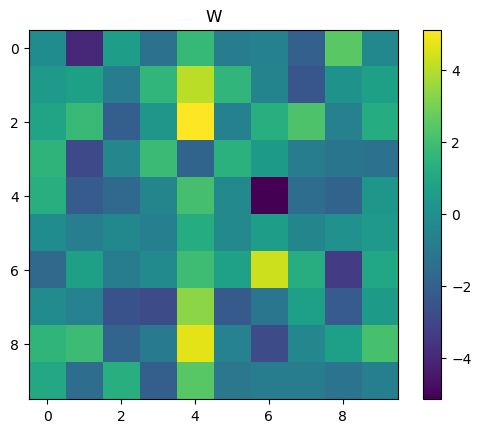

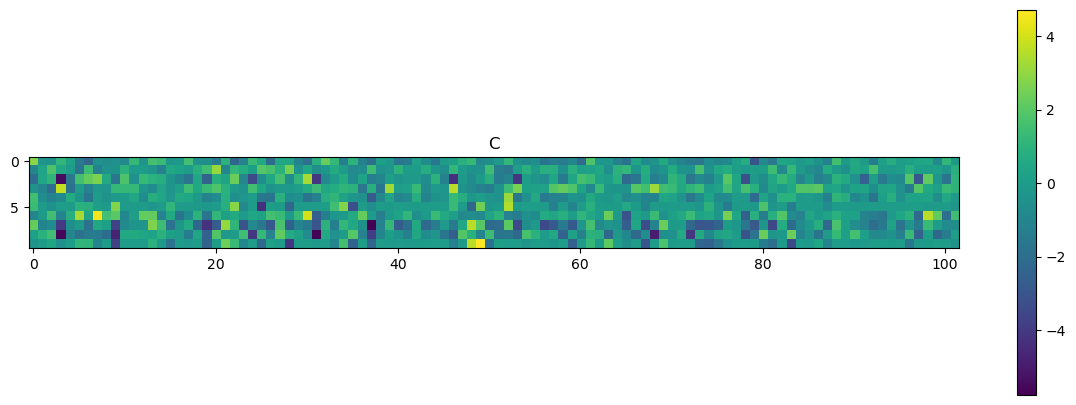

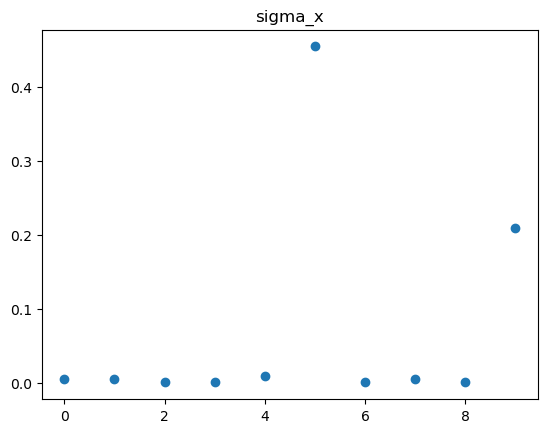

Parameter containing:
tensor(-0.8743, device='cuda:0', requires_grad=True) d


In [6]:
# # for name, prm in model.named_parameters():
# #     print(f'Name: {name} - Shape: {prm.shape} - Parameter: {prm}')
# print('sigma_x', model.sigma_x)
# print('d', model.d)
print((model.C @ model.W).sum(axis=-1))
# print(torch.diag(model.Q[0]))
# print(torch.diag(model.Sigma0[0]))

# print(torch.linalg.eigvals(model.A))

# # print(model.lik.total_count)

plt.imshow(model.W[0].detach().cpu().numpy())
plt.colorbar()
plt.title('W')
plt.show()

plt.figure(figsize=(15, 5))  # Adjust as needed
plt.imshow(model.C[0].detach().cpu().numpy().T)
plt.colorbar()
plt.title('C')
plt.show()

plt.plot(model.sigma_x.detach().cpu().numpy(), 'o')
plt.title('sigma_x')
plt.show()

print(model.d, 'd')
# print(model.lik.sigma, 'sigma')

step 0 LL -9.207607230392156
step 1 LL -341.0317647058824
step 2 LL -19.49801286764706
step 3 LL -16.415292279411766
step 4 LL -13.506695465686274
step 5 LL -13.037905024509804
step 6 LL -9.383260416666667
step 7 LL -9.940332107843137
step 8 LL -8.635345281862746
step 9 LL -6.290948835784314
step 10 LL -5.841654411764706
step 11 LL -5.539019914215686
step 12 LL -4.1978535539215684
step 13 LL -4.2645586703431375
step 14 LL -5.211819240196078
step 15 LL -4.675266544117647
step 16 LL -3.2754085477941177
step 17 LL -2.9221317401960785
step 18 LL -3.7868913909313724
step 19 LL -4.040289522058823
step 20 LL -2.8096230085784315
step 21 LL -1.8971328125
step 22 LL -2.422659926470588
step 23 LL -3.0669430147058825
step 24 LL -2.6800617340686275
step 25 LL -1.8615464154411765
step 26 LL -1.6763164828431372
step 27 LL -2.1023318780637257
step 28 LL -2.201480851715686
step 29 LL -1.7854472273284314
step 30 LL -1.541536075367647
step 31 LL -1.6422084865196078
step 32 LL -1.701112668504902
step 33 L

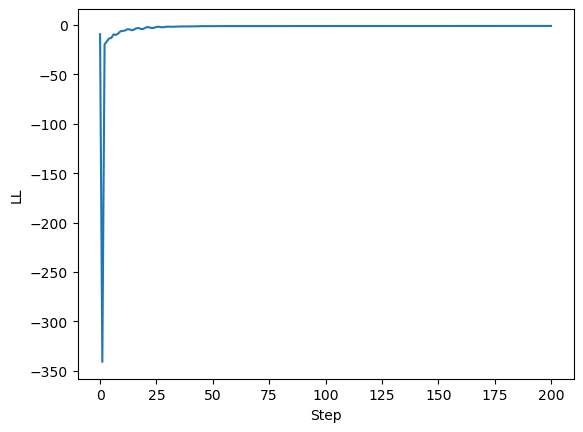

In [7]:
model.freeze_params()
class MyRNNModel(Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyRNNModel, self).__init__()
        self.rnn = torch.nn.RNN(input_size, hidden_size, batch_first=True, bidirectional=True, num_layers=2)
        self.fc = torch.nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out

neural_net = MyRNNModel(model.N, 100, model.x_dim)

rec_model = RecognitionModel(model, rnn=True, neural_net=neural_net)
train_params = {'batch_size': None, 'step_size': 100, 'lrate': 5e-3, 'max_steps': 201, 'n_mc_x': 25, 'n_mc_z': 100, 'batch_mc_z': 50}
rec_model.train_recognition_model(rec_model.training_params(**train_params))
rec_model.plot_LL()

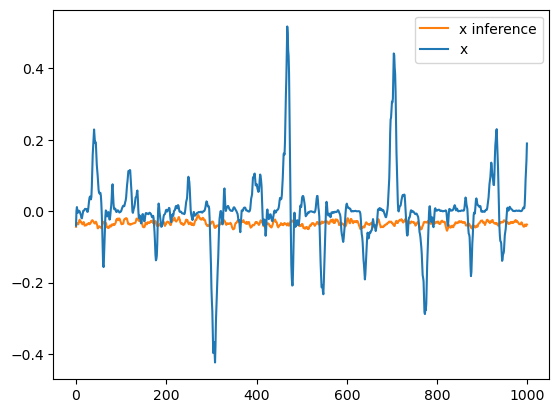

-0.13929530351373476
-0.056995430202157804


In [9]:

z = rec_model.test_z(rec_model.gen_model.Y)

# Y_test = Y[..., train_len:]
# z = rec_model.test_z(Tensor(Y_test).to(device))

z = z.detach().cpu().numpy()

z = z.reshape(1,-1,1000)
W = np.load('params/W' + suffix + '.npy')
z = W @ z

train_len = 1000
# _vels = vels[train_len:]
_vels = vels[:train_len]

plt.plot(z[0,0,:], label = 'x inference', color = 'C1')
# plt.plot(z[0,1,:], label = 'y inference', color = 'C1')
plt.plot(_vels[:, 0], label = 'x', color = 'C0')
# plt.plot(_vels[:, 1], label = 'y', color = 'C0')
plt.legend()
plt.show()

# print R^2 for x and y decoding using sklearn
print(r2_score(_vels[:, 0], z[0,0,:]))
print(r2_score(_vels[:, 1], z[0,1,:]))